In [1]:
import xarray as xr # needed for reading data
import pandas as pd # Used for stroing data
import numpy as np
import pickle as pkl  # Needed for saving model objects
import os
from itertools import repeat # Needed for repeating a variable multiple times

import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels.api as sm    # Used for bot he SARIMA and SARIMAX models
import statsmodels.tsa as sm_tsa # Used for type checking SARIMA models
from sklearn import metrics     # Used for importing various performance measures

In [2]:
# Depending on the machine on which the code is run, data might be stored in different directories.
# Indicate which machine is used to make sure the path to the data can be found.
# Can either be "local" or "Snellius"

MACHINE = 'local'

if MACHINE == 'Snellius':
    pred_var_path = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/trained_models/' # used for storing the trained model

    SF_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/results/' # used for storing the trained model

elif MACHINE == 'local':
    pred_var_path = './' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = './models/' # used for storing the trained model

    SF_DIR = './fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = './results/'


SARIMA_params = {'order': (2,0,2),             # Defining the regular AR, I and MA dependencies
                 'seasonal_order': (1,0,1,52), # Defining the seasonal dependencies
                 'trend': 'c'                  # Adding an intercept term
                 }


In [3]:
results = pd.read_pickle(RESULTS_DIR + 'SARIMA_results.pkl')
results

,eco_region,start_year,N_train_years,N_train_obs,N_test_years,N_test_obs,sf_ME_train,sf_MAE_train,sf_MAPE_train,sf_RMSE_train,...,sf_ME_test,sf_MAE_test,sf_MAPE_test,sf_RMSE_test,sf_r2_test,flux_ME_test,flux_MAE_test,flux_MAPE_test,flux_RMSE_test,flux_r2_test
0,1.0,2000.0,17.0,888.0,4.0,208.0,-0.009232,0.487816,2.394147,1.254766,...,0.228802,0.529359,3.003043,1.595191,0.027558,133077.566252,6.537621e+05,3.003043,9.207312e+05,0.822309
1,1.0,2001.0,16.0,835.0,4.0,208.0,-0.011331,0.497716,2.470909,1.288604,...,0.226850,0.527760,3.002534,1.594292,0.028654,135104.094187,6.513342e+05,3.002534,9.180563e+05,0.823340
2,1.0,2002.0,15.0,783.0,4.0,208.0,-0.009003,0.504269,2.540321,1.322838,...,0.246037,0.528744,2.980659,1.595990,0.026583,141990.258108,6.553579e+05,2.980659,9.276895e+05,0.819614
3,1.0,2003.0,14.0,731.0,4.0,208.0,-0.008667,0.511836,2.624719,1.360882,...,0.258024,0.533395,2.964086,1.597342,0.024934,148888.512423,6.642546e+05,2.964086,9.395337e+05,0.814978
4,1.0,2004.0,13.0,679.0,4.0,208.0,-0.002227,0.518214,2.704347,1.382924,...,0.293266,0.543004,2.967454,1.602681,0.018405,169832.390525,6.783322e+05,2.967454,9.613780e+05,0.806274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,209.0,2012.0,5.0,261.0,4.0,208.0,-0.010545,0.961381,1.901331,2.460055,...,-0.210844,0.992269,1.502556,2.585333,-0.096349,8848.029975,7.465397e+04,1.502556,1.005205e+05,0.665860
13,209.0,2013.0,4.0,209.0,4.0,208.0,-0.000890,1.101043,1.526651,2.608197,...,-0.130500,1.411046,2.099838,2.685815,-0.183227,8355.232172,1.342461e+05,2.099838,1.686980e+05,0.058891
14,209.0,2014.0,3.0,157.0,4.0,208.0,-0.001446,0.882966,1.692831,2.450382,...,-0.193162,0.928032,1.305508,2.493493,-0.019840,7230.680039,6.944591e+04,1.305508,9.459103e+04,0.704117
15,209.0,2015.0,2.0,105.0,4.0,208.0,-0.005321,0.790040,1.580850,2.180317,...,-0.352094,0.941755,1.420687,2.507109,-0.031008,8462.551409,6.960762e+04,1.420687,9.598024e+04,0.695362


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


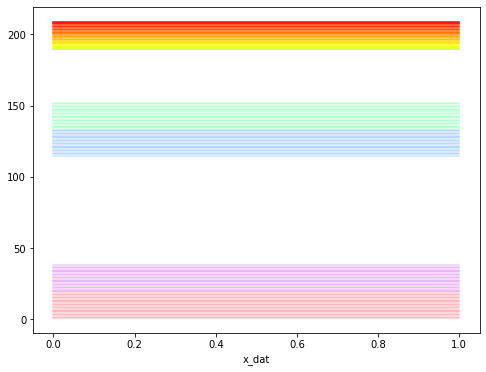

In [71]:

mock_regions = np.concatenate([range(1,20), range(20,39), range(115, 134), range(134, 153), range(190, 210)])

color_dat = np.interp(mock_regions, [1,19,20,38,115,133,134,152,190,209],
                   [0, 0,# color TC region 1
                    0.2, 0.2, # color TC region 2
                    0.4, 0.4, # color TC region 7
                    0.6, 0.6, # color TC region 8
                    0.8, 1]) # color range TC 11

mock_x = np.linspace(0, 1, 10)
first_entry = zip([mock_regions[0]]*len(mock_x), mock_x, [mock_regions[0]]*len(mock_x))
mock_df = pd.DataFrame(first_entry, columns=['region', 'x_dat', 'y_dat'])
for region in mock_regions[1:]:
    data_triples = zip([region]*len(mock_x), mock_x, [region]*len(mock_x))
    new_entry = pd.DataFrame(data_triples, columns=['region', 'x_dat', 'y_dat'])
    mock_df= pd.concat([mock_df, new_entry], ignore_index = True)
# continent_dict = {1:'North American Boreal',
#                    2:'North American Temperate',
#                    7:'Eurasia Boreal',
#                    8:'Eurasia Temperate',
#                    11:'Europe',
#                   }
# continent_to_index = {1:0,
#                    2:1,
#                    7:2,
#                    8:3,
#                    11:4,
#                   }

fig, ax = plt.subplots(figsize=(8,6))

#norm = mpl.colors.Normalize(vmin=0, vmax=12000, clip=True)
cmap = plt.get_cmap('RdYlGn_r')  # From red to green

# print(mock_df)
colors = plt.cm.hsv_r(color_dat)
alphas = [1 if r>=190 else 0.2 for r in mock_regions]

colors[:,-1] = alphas

mock_df = mock_df.set_index(['x_dat','region'])
mock_df.unstack(['region']).xs('y_dat', axis=1).plot(colormap='jet', color=colors, ax=ax, legend=False)
# mock_df.groupby('region').plot('x_dat', 'y_dat', cmap=cmap, ax=ax)
# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical',
#                                 ticks=[100, 1000, 10000])
# cb1.set_clim(0,12000)
plt.show()

In [65]:
colors

array([[0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314, 0.21568627, 0.5       ],
       [0.        , 0.40784314,

In [39]:
alphas

[0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

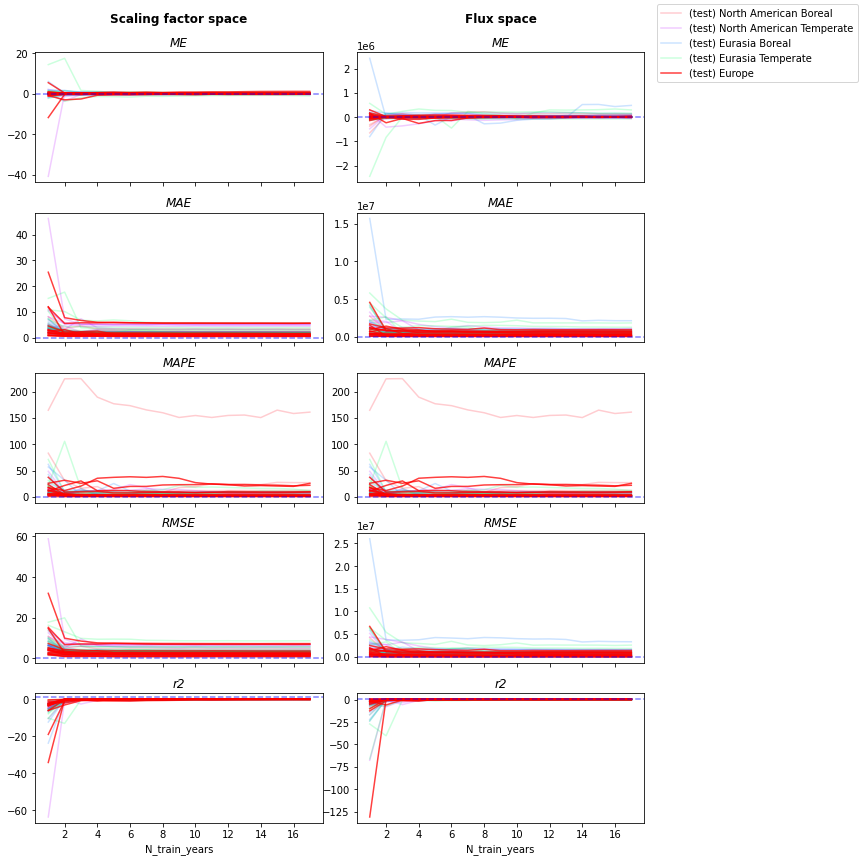

In [53]:
def det_colors(regions, color_ranges):
    color_pos = np.interp(regions,
                     [1,19,20,38,115,133,134,152,190,209],
                     np.concatenate(list(color_ranges.values())))
    return plt.cm.hsv_r(color_pos)

plot_train = False

results = pd.read_pickle(RESULTS_DIR + 'SARIMA_results.pkl')
regions = np.unique(results.eco_region)


results = results.set_index(['N_train_years','eco_region'])
trans_color_dict = {1:[0,0], # color TC region 1
                   2:[0.2, 0.2], # color TC region 2
                   7:[0.4, 0.4], # color TC region 7
                   8:[0.6, 0.6], # color TC region 8
                   11:[1,1], # color TC region 11
                  }

trans_alpha_dict = {1:0.2, # alpha TC region 1
                   2:0.2, # alpha TC region 2
                   7:0.2, # alpha TC region 7
                   8:0.2, # alpha TC region 8
                   11:0.75, # alpha TC region 11
                  }

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

colors = det_colors(regions, trans_color_dict)
alphas = [trans_alpha_dict[int((r-1)/19)+1] for r in regions]

colors[:,-1] = alphas
#
# transcom_colors = plt.cm.rainbow(np.linspace(0, 1, 5))
#
# color_dict = {key: color for key, color in zip(range(1,20),europe_colors)}

# colors = colors[:len(regions)]
# results.groupby('eco_region').plot('start_year', 'flux_MAE_test')
fig, ax = plt.subplots(5,2,figsize=(12,12), sharex=True)

for i, perf_mes in enumerate(['ME', 'MAE', 'MAPE', 'RMSE', 'r2']):
    if plot_train:
        results.unstack(['eco_region']).xs('sf_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][0], legend=False, linestyle=':')

        results.unstack(['eco_region']).xs('flux_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][1], legend=False, linestyle=':')

    results.unstack(['eco_region']).xs('sf_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][0], legend=False)

    results.unstack(['eco_region']).xs('flux_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][1], legend=False)
    #
    # df.plot('N_train_years', 'sf_'+perf_mes + '_train', ax=ax[i][0], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'flux_'+perf_mes + '_train', ax=ax[i][1], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'sf_'+perf_mes + '_test', ax=ax[i][0], label='test_'+str(label), color=color_dict[label])
    # df.plot('N_train_years', 'flux_'+perf_mes + '_test', ax=ax[i][1], label='test_'+str(label), color=color_dict[label])
    ax[i][0].set_title(perf_mes, style='italic')
    ax[i][1].set_title(perf_mes, style='italic')

for i in range(4):
    ax[i][0].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')
    ax[i][1].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')

ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')

pad = 30 # in points

for ax, col_name in zip(ax[0], ['Scaling factor space', 'Flux space']):
    ax.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

len_legend = 10 if plot_train else 5
handles = [None]*len_legend
labels = [None]*len_legend

for dict_item, i in zip(continent_dict.items(),range(5)):
    color = list(det_colors(dict_item[0]*19, trans_color_dict))
    color[-1] = trans_alpha_dict[dict_item[0]]
    handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color)
    labels[i] = '(test) ' + dict_item[1]

if plot_train:
    for dict_item, i in zip(continent_dict.items(),range(len_legend/2, len_legend)):
        color = list(det_colors(dict_item[0]*19, trans_color_dict))
        color[-1] = trans_alpha_dict[dict_item[0]]
        handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
        labels[i] ='(train) ' + dict_item[1]


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.tight_layout()

fig.subplots_adjust(right=0.75)   ##  Need to play with this number to make column names and legend fit.

fig.legend(handles, labels, loc="upper right", ncol=1)


# handles, _ = ax[4][0]
# handles.append(ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target'))
#
# handles, _ = ax[4][1].get_legend_handles_labels()
# handles.append(ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target'))


# plt.legend()
plt.show()

In [20]:
np.ndarray(2)

array([  1., 209.])

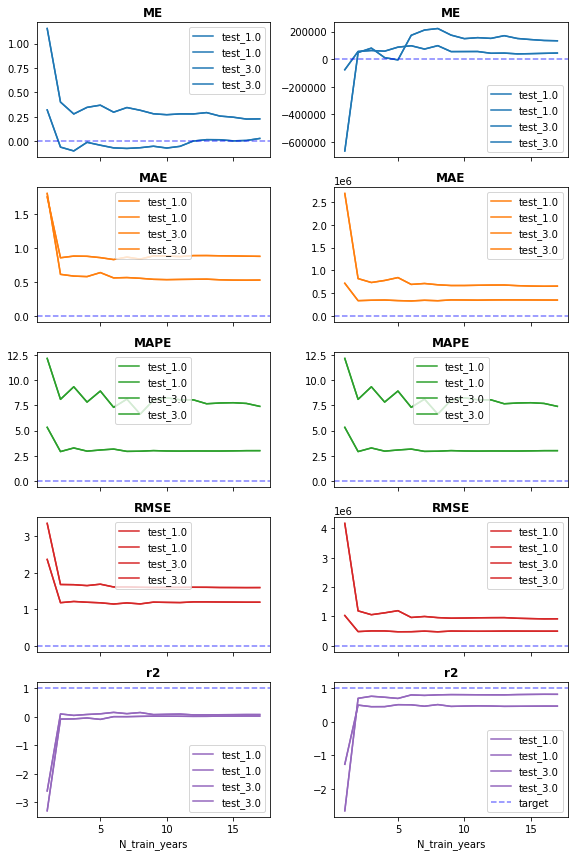

In [9]:
results = pd.read_pickle(RESULTS_DIR + 'SARIMA_results.pkl')

# results.groupby('eco_region').plot('start_year', 'flux_MAE_test')
fig, ax = plt.subplots(5,2,figsize=(8,12), sharex=True)
for label, df in results.groupby('eco_region'):
    for i, perf_mes in enumerate(['ME', 'MAE', 'MAPE', 'RMSE', 'r2']):
        df.plot('N_train_years', 'sf_'+perf_mes + '_train', ax=ax[i][0], label='train_'+str(label), color=color_dict[label], linestyle=':')
        df.plot('N_train_years', 'flux_'+perf_mes + '_train', ax=ax[i][1], label='train_'+str(label), color=color_dict[label], linestyle=':')
        df.plot('N_train_years', 'sf_'+perf_mes + '_test', ax=ax[i][0], label='test_'+str(label), color=color_dict[label])
        df.plot('N_train_years', 'flux_'+perf_mes + '_test', ax=ax[i][1], label='test_'+str(label), color=color_dict[label])
        ax[i][0].set_title(perf_mes, fontweight="bold")
        ax[i][1].set_title(perf_mes, fontweight="bold")


df = results[(results.eco_region == 1)]

for i in range(4):
    ax[i][0].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')
    ax[i][1].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')



# handles, _ = ax[4][0].get_legend_handles_labels()
# handles.append(ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target'))
#
# handles, _ = ax[4][1].get_legend_handles_labels()
# handles.append(ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target'))
ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')

plt.legend()
plt.tight_layout()
plt.show()

In [34]:
labels = ["some name", "some other name", "horizontal"]
handles